## Training model using Xboost and validating robustness with k-fold cross validation


In [2]:
import pandas as pd

df = pd.read_csv('../dataset/data_cleaned.csv') ##need to replace with ur own path

In [3]:
df.head()

,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,...,required_education,industry,function,fraudulent,country,state,city,description_cleaned,requirements_cleaned,benefits_cleaned
0,Senior Sales Professionals,Sales/Marketing,Not Provided,Not Provided,Do YOU have the sales skills or entrepreneuria...,Not Provided,Not Provided,0,0,0,...,High School or equivalent,Unknown,Sales,1,US,IN,Indianapolis,sale skill entrepreneurial drive join usflexko...,provided,provided
1,Medical Surgical RN,Not Provided,Not Provided,Not Provided,Find more jobs at #URL_4708e598004bb0a85bf09f9...,Not Provided,Not Provided,0,0,0,...,Unknown,Hospital & Health Care,Unknown,1,US,CA,Unknown,find job url_ebbabffeeccaffdcfedebeeffeapply l...,provided,provided
2,Senior Mechanical Design Engineer,Not Provided,Not Provided,Aker Solutions is a global provider of product...,Corporate overviewAker Solutions is a global p...,Qualifications &amp; personal attributes :Degr...,We offer :• Friendly colleagues in an industry...,0,1,0,...,Unknown,Oil & Energy,Engineering,1,US,TX,Houston,corporate overviewaker solution global provide...,qualification amp personal attribute degree me...,offer friendly colleague industry bright futur...
3,franciscan st. francis health,Not Provided,Not Provided,Not Provided,Apply using below link#URL_ff6a6560a6c8ffc9abc...,Not Provided,Not Provided,0,0,0,...,Unknown,Hospital & Health Care,Unknown,1,US,IN,Indianapolis,apply using linkurl_ffaacffcabcecadddaddeddedf...,provided,provided
4,Director of Peri-Anesthesia,Not Provided,Not Provided,Not Provided,Apply using below link directly#URL_af5a535903...,Not Provided,Not Provided,0,0,0,...,Unknown,Hospital & Health Care,Unknown,1,US,MA,Unknown,apply using link directlyurl_afaaacceabcdfaeda...,provided,provided


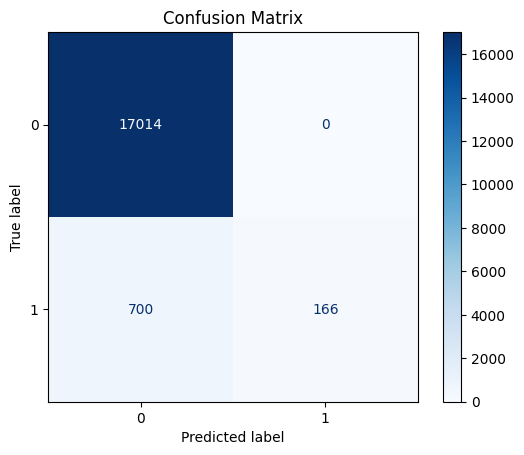

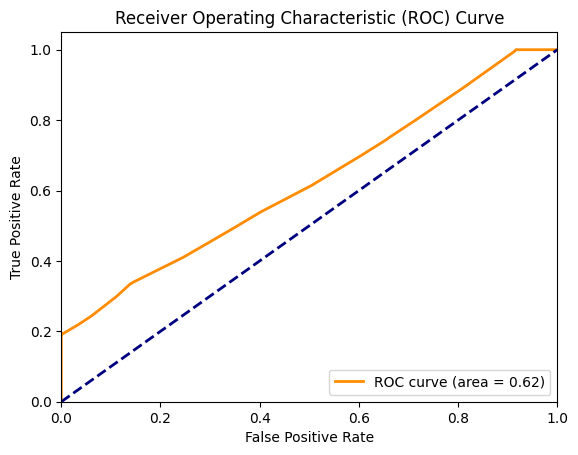

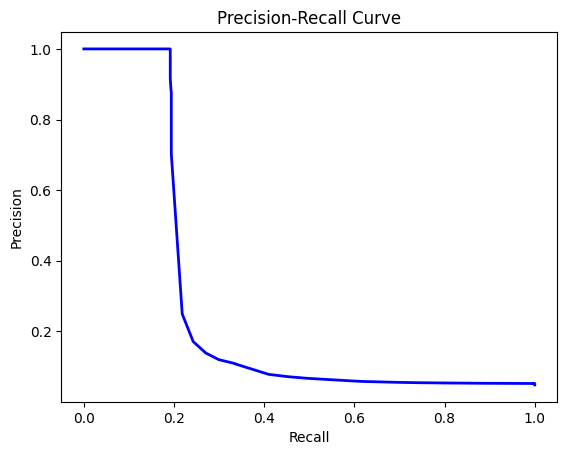

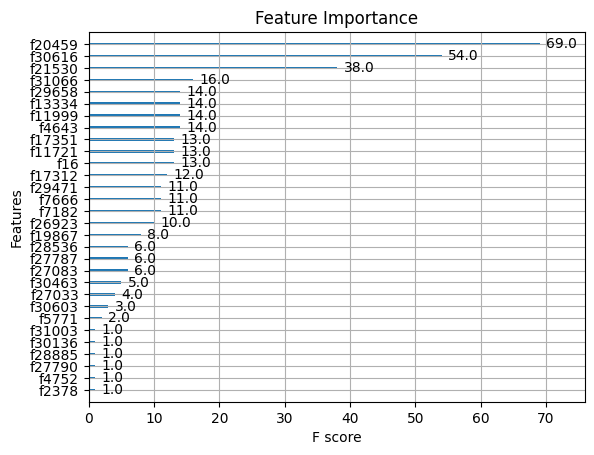

In [4]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Assuming the data is already loaded into df
# df = pd.read_csv('your_dataset.csv')

# 1. Define feature columns and target variable
X = df.iloc[:, -3:]  # Last 3 columns as features
y = df.iloc[:, -7]   # 'fraudulent' column as target

# 2. Setup one-hot encoding for the string columns
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# 3. Create pipeline
model = xgb.XGBClassifier()
pipeline = Pipeline(steps=[('onehot', onehot_encoder), ('model', model)])

# 4. KFold Cross-validation for model evaluation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(pipeline, X, y, cv=kfold)

# 5. Confusion Matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# 6. ROC Curve
y_pred_proba = cross_val_predict(pipeline, X, y, cv=kfold, method='predict_proba')[:, 1]
fpr, tpr, _ = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 7. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y, y_pred_proba)
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# 8. Feature Importance (for XGBoost model)
pipeline.fit(X, y)
model = pipeline.named_steps['model']
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()
